In [102]:
# standard libraries
import math
import os
import tempfile
from pathlib import Path

# standard scientific libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray, save, load
import pandas as pd
import seaborn as sns

# scikit-learn
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from keras.optimizers import RMSprop
from keras.utils import to_categorical

TODO
- fragment length (8- 14)
- classifier vs. single-sequence (GNRA)
- with/without decoys

ADD VALIDATION SET

# Model

In [104]:
# Config (hyperparameters, metrics, etc.)

DATA_DIR = Path("../data_generation/training_data/gnra_8_80_T/")
EPOCHS = 20
BATCH_SIZE = 16
NUM_CLASSES = 2
METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'),
      # keras.metrics.BinaryAccuracy(name = 'accuracy'), # TODO remove this?
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'auc'),
      keras.metrics.AUC(name = 'prc', curve = 'PR'), # precision-recall curve
      tfa.metrics.F1Score(name = 'f1', num_classes = NUM_CLASSES),
      tfa.metrics.MatthewsCorrelationCoefficient(name = 'mcc', num_classes = NUM_CLASSES)
]

In [106]:
# Load dataset

train_dict = np.load(DATA_DIR/"train_matrices.npz", allow_pickle=True)
x_train = np.stack(train_dict['arr_0'], axis=0)
y_train = np.load(DATA_DIR/"train_labels.npy", allow_pickle=True) # TODO as_type(int) needed?
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)  # TODO categorical, one-hot encode labels

test_dict = np.load(DATA_DIR/"test_matrices.npz", allow_pickle=True)
x_test = np.stack(test_dict['arr_0'], axis=0)
y_test = np.load(DATA_DIR/"test_labels.npy", allow_pickle=True)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

dev_dict = np.load(DATA_DIR/"dev_matrices.npz", allow_pickle=True)
x_dev = np.stack(dev_dict['arr_0'], axis=0)
y_dev = np.load(DATA_DIR/"dev_labels.npy", allow_pickle=True)
y_dev = to_categorical(y_dev, num_classes=NUM_CLASSES)

#! Merge dev and test sets (if validation set not used)
# x_test = np.concatenate((x_test, x_dev), axis=0)
# y_test = np.concatenate((y_test, y_dev), axis=0)

print("training features shape:", x_train.shape)
print("training labels shape:", y_train.shape)

print("\ntesting features shape:", x_test.shape)
print("testing labels shape:", y_test.shape)

print("\ndev (validation) features shape:", x_dev.shape)
print("dev (validation) labels shape:", y_dev.shape)

print("\ninput shape:", x_train.shape[1:])

INPUT_SHAPE = x_train.shape[1:]

training features shape: (33084, 8, 5)
training labels shape: (33084, 2)

testing features shape: (4136, 8, 5)
testing labels shape: (4136, 2)

dev (validation) features shape: (4135, 8, 5)
dev (validation) labels shape: (4135, 2)

input shape: (8, 5)


In [4]:
def make_model(metrics=METRICS, output_bias=None, input_shape=INPUT_SHAPE, pool_size = 2):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = Sequential([        
        # First convolution
        Conv1D(16, 3, strides=1, activation='relu', padding='same', # TODO set as 64?
               input_shape = input_shape,
               kernel_initializer = 'he_normal',
               bias_initializer = 'zeros'),
        MaxPooling1D(pool_size = pool_size, strides = 2), # TODO set strides?
        Dropout(0.2),
        Conv1D(32, 3, strides = 1, activation = 'relu', padding = 'same',
               kernel_initializer = 'he_normal',
               bias_initializer = 'zeros'),
        MaxPooling1D(pool_size = pool_size, strides = 2),
        Dropout(0.2),
        Flatten(),
        
        # Neuron hidden layer
        Dense(int(INPUT_SHAPE[0]/pool_size) * 32, activation = 'relu', kernel_initializer='he_normal', bias_initializer = output_bias),
        Dropout(0.2),
        
        # Output neuron
        # Dense(1, activation='sigmoid')  # Sigmoid for binary question. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
        Dense(NUM_CLASSES, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform') # TODO categorical: Softmax for multiclass classification
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate = 1e-3),  # optimizer=RMSprop(lr=0.001),
        loss=keras.losses.CategoricalCrossentropy(), 
        # loss=keras.losses.BinaryCrossentropy(), # TODO remove?
        metrics=metrics)

    return model

In [5]:
# Calculate class weight

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
y_integers = np.argmax(y_train, axis=1)
class_weights = np.round(class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers), 2)
d_class_weights = dict(enumerate(class_weights))

print(d_class_weights)

{0: 0.54, 1: 7.23}


In [6]:
# Train with class weights

model = make_model()
#weighted_model.load_weights(initial_weights)

history = model.fit(
    x_train,
    y_train,
    validation_data = (x_dev, y_dev),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    
    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-05-01 17:10:24.422962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


2068/2068 [==============================] - 12s 4ms/step - loss: 0.3468 - tp: 27931.0000 - fp: 5153.0000 - tn: 27931.0000 - fn: 5153.0000 - accuracy: 0.8442 - precision: 0.8442 - recall: 0.8442 - auc: 0.9280 - prc: 0.9299 - f1: 0.6720 - mcc: 0.4436 - val_loss: 0.1961 - val_tp: 3822.0000 - val_fp: 313.0000 - val_tn: 3822.0000 - val_fn: 313.0000 - val_accuracy: 0.9243 - val_precision: 0.9243 - val_recall: 0.9243 - val_auc: 0.9764 - val_prc: 0.9759 - val_f1: 0.7954 - val_mcc: 0.6473
Epoch 2/20
2068/2068 [==============================] - 8s 4ms/step - loss: 0.2145 - tp: 30071.0000 - fp: 3013.0000 - tn: 30071.0000 - fn: 3013.0000 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9713 - prc: 0.9713 - f1: 0.7668 - mcc: 0.5928 - val_loss: 0.2457 - val_tp: 3738.0000 - val_fp: 397.0000 - val_tn: 3738.0000 - val_fn: 397.0000 - val_accuracy: 0.9040 - val_precision: 0.9040 - val_recall: 0.9040 - val_auc: 0.9644 - val_prc: 0.9634 - val_f1: 0.7606 - val_mcc: 0.5957
Epoch 3/20
2068/20

In [7]:
# Predictions (test set)

train_predictions = model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(x_test, batch_size=BATCH_SIZE)

259/259 [==============================] - 0s 1ms/step


# Plots

In [108]:
# Config

mpl.rcParams['figure.figsize'] = [8, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

SET_NAME = str(DATA_DIR).split("/")[-1]
RESULTS_DIR = Path(f"results/{SET_NAME}")
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [113]:
# Plotting functions # TODO make plots pretty

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], color=colors[0], linestyle="--", label='Test')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()


def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
    # plt.semilogy(history.epoch, history.history['val_loss'],
    #              color=colors[n], label='Val ' + label,
    #              linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')


def plot_cm(labels, predictions, p=0.5): # TODO random threshold selected for CM
    cm = confusion_matrix(labels, predictions > p) 
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('Non-GNRA Detected (True Negatives): ', cm[0][0])
    print('Non-GNRA Incorrectly Detected (False Positives): ', cm[0][1])
    print('GNRA Missed (False Negatives): ', cm[1][0])
    print('GNRA Detected (True Positives): ', cm[1][1])
    print('Total GNRA: ', np.sum(cm[1]))


def plot_roc(name, labels, predictions, **kwargs):
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)
    
    plt.rcParams['font.size'] = '16'
    plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives rate = fp/(fp+tn)')
    plt.ylabel('True positives rate = tp/(tp+fn)')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc='lower right')


def plot_prc(name, labels, predictions, **kwargs):  #precision = tp / (tp + fp), recall = tp / (tp + fn)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.rcParams['font.size'] = '9'
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall = TP / (TP + FP)')
    plt.ylabel('Precision = TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc='upper right')

loss :  0.1038636565208435
tp :  4001.0
fp :  135.0
tn :  4001.0
fn :  135.0
accuracy :  0.9673597812652588
precision :  0.9673597812652588
recall :  0.9673597812652588
auc :  0.9918291568756104
prc :  0.9907932281494141
f1 :  [0.9821357  0.81118876]
mcc :  0.8087809085845947


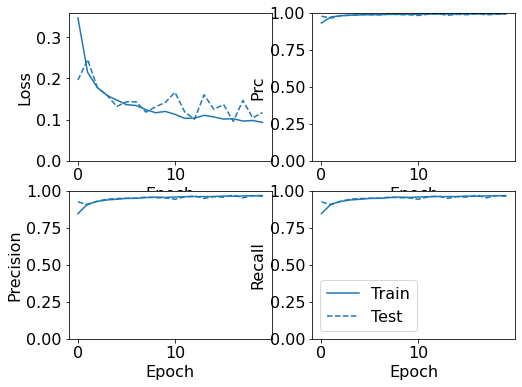

In [114]:
# Results of test data set. 
results = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plot_metrics(history)
plt.savefig(f"{RESULTS_DIR}/metrics.png")

Non-GNRA Detected (True Negatives):  3711
Non-GNRA Incorrectly Detected (False Positives):  130
GNRA Missed (False Negatives):  5
GNRA Detected (True Positives):  290
Total GNRA:  295


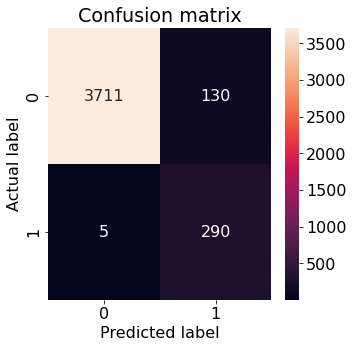

In [115]:
plot_cm(y_test.argmax(axis=1), test_predictions.argmax(axis=1))
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png")

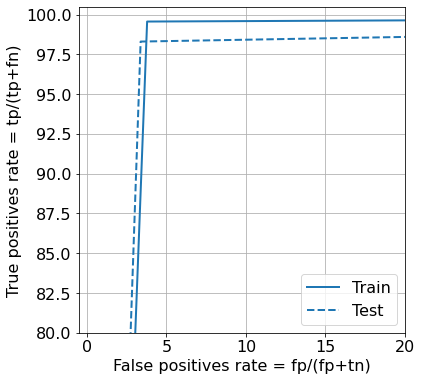

In [116]:
plot_roc("Train", y_train.argmax(axis=1), train_predictions.argmax(axis=1), color=colors[0])
plot_roc("Test", y_test.argmax(axis=1), test_predictions.argmax(axis=1), color=colors[0], linestyle='--')

plt.savefig(f"{RESULTS_DIR}/roc.png")

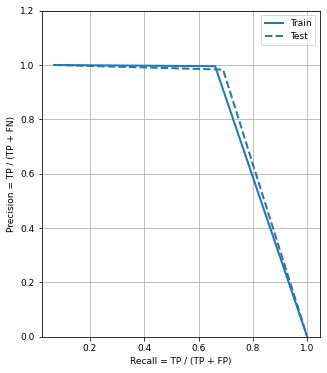

In [117]:
plot_prc("Train", y_train.argmax(axis=1), train_predictions.argmax(axis=1), color=colors[0])
plot_prc("Test", y_test.argmax(axis=1), test_predictions.argmax(axis=1), color=colors[0], linestyle='--')
# plt.xlim([0, 1.2])
plt.ylim([0, 1.2])

plt.savefig(f"{RESULTS_DIR}/prc.png")